In [113]:
import numpy as np
import scipy.optimize as opt

import pandas as pd

import pyretina

%matplotlib inline

import matplotlib.pyplot as plt

DATA_PATH = "./data/MC/"

In [114]:
from ipyparallel import Client

rc = Client()

lview = rc.load_balanced_view()

In [115]:
def scan_dir(data_path):
    import os
    import re
    r = re.compile("\\d+[_]\\d+")
    
    return list(set([
                "%s/%s" % (data_path, r.findall(item)[0])
                for item in os.listdir(data_path)
                if len(r.findall(item)) > 0
            ]))

def load_event(item):
    hits = pd.DataFrame.from_csv("%s.hits.csv" % item)[['X', 'Y', 'Z']].values
    tracks = pd.DataFrame.from_csv("%s.tracks.csv" % item)

    tx = tracks[ [u'x%d' % i for i in range(11) ] ].values
    ty = tracks[ [u'y%d' % i for i in range(11) ] ].values
    tz = tracks[ [u'z%d' % i for i in range(11) ] ].values
    return hits, (tx, ty, tz)
    
def load_events(event_names):
    events = list()
    for item in event_names:
        try:
            events.append(load_event(item))
        except:
            pass

    return events

In [116]:
events = load_events(scan_dir(DATA_PATH))

In [117]:
len(events)

2573

In [118]:
zs = np.hstack([ hits[:, 2] for hits, _ in events ])

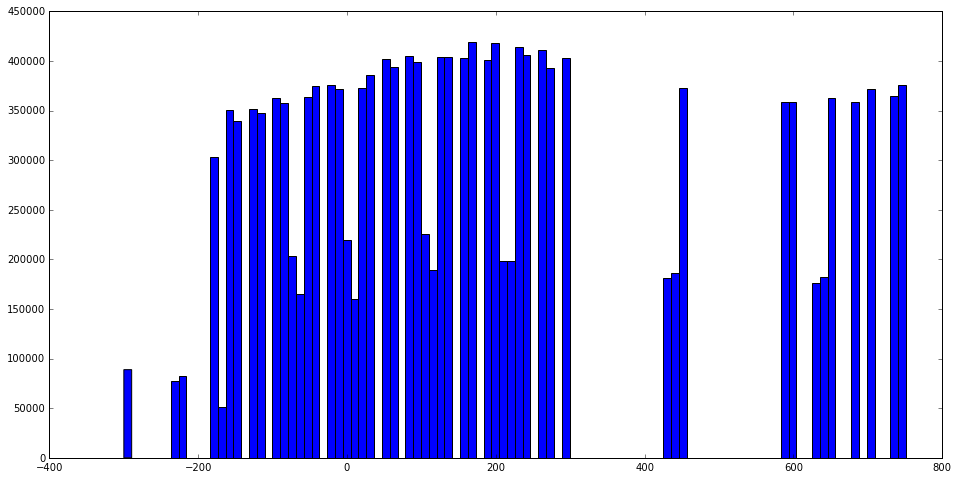

In [119]:
plt.figure(figsize=(16, 8))
plt.hist(zs[zs < 2000], bins=100)
plt.show()

In [120]:
magnetic_field_cut = 5000
before_cut = np.max(zs[zs < 5000]) + 0.1
after_cut = np.min(zs[zs > 5000]) - 0.1

In [121]:
velo_cut = 800
magnet_cut = before_cut
print after_cut

7652.44


In [122]:
from sklearn.linear_model import LinearRegression

def cut_event(hits, tracks):
    lr = LinearRegression(fit_intercept=False)
    tx, ty, tz = tracks

    hits_ = hits[hits[:, 2] < velo_cut]
    
    tracks_ = list()
    
    for i in xrange(tx.shape[0]):
        xs = tx[i, :]
        ys = ty[i, :]
        zs = tz[i, :]
        
        if np.sum(zs < before_cut) < 2:
            continue
        
        lr.fit(zs.reshape(-1, 1), xs)
        cx = lr.coef_[0]
        
        assert lr.score >= 0.98
        
        lr.fit(zs.reshape(-1, 1), ys)
        cy = lr.coef_[0]
        
        assert lr.score >= 0.98

        tracks_.append((cx, cy))

    return (hits_, np.array(tracks_))

In [123]:
def cuted(events):
    for event in events:
        hits, tracks = cut_event(*event)
        if hits.shape[0] > 0 and tracks.shape[0] > 0:
            yield (hits, tracks)

In [124]:
velo_events = list(cuted(events))

for i in xrange(len(velo_events)):
    hits, tracks = velo_events[i]
    np.savetxt("./data/velo_events/%d.hits.csv" % i, hits)
    np.savetxt("./data/velo_events/%d.tracks.csv" % i, tracks)

In [125]:
len(velo_events)

2405

In [14]:
from pyretina.geometry import *

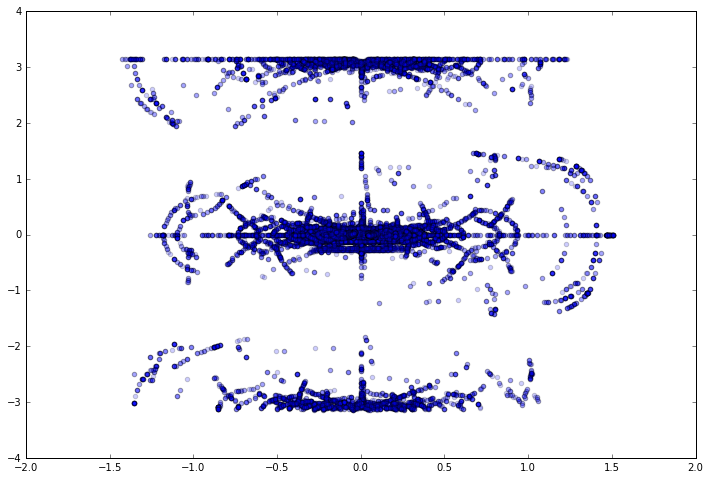

In [23]:
plt.figure(figsize=(12, 8))
for i in range(10):
    hits, _ = velo_events[i]
    for j in xrange(hits.shape[0]):
        hits[j, :] /= np.sqrt(np.sum(hits[j, :] ** 2))

    sps = to_spherical(hits)
    plt.scatter(sps[:, 0], sps[:, 1], alpha = 0.1)

plt.show()

In [126]:
h, tracks = velo_events[1]

In [127]:
from pyretina.retina_event import RetinaEvent

re = RetinaEvent(h, None, 1.0, [ -0.1, 0.1], 250, [ -0.1, 0.1 ], 250)

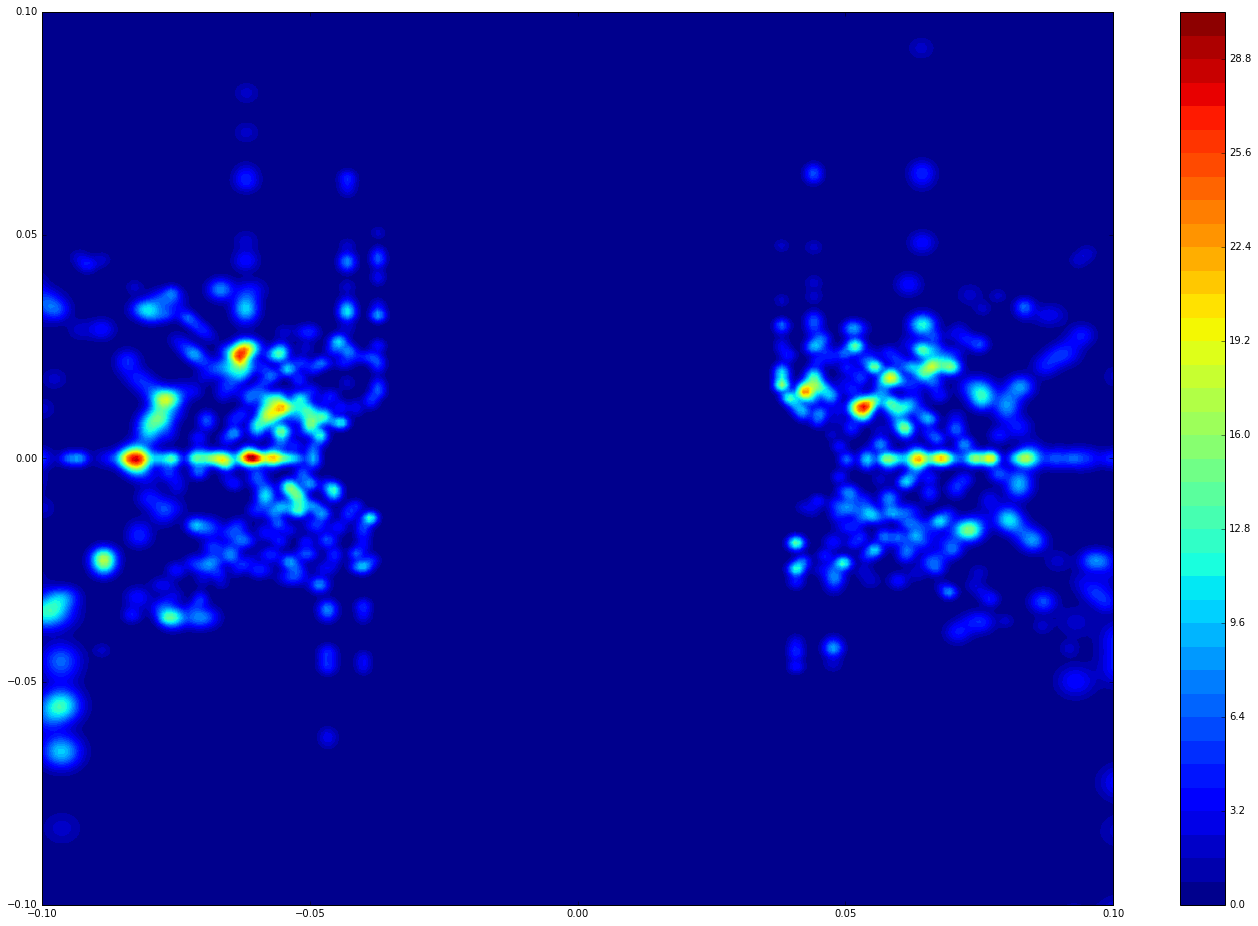

In [128]:
plt.figure(figsize=(24, 16))
thetas, phis, rr = re.get_grid()
plt.contourf(thetas, phis, rr, 40)
plt.colorbar()
plt.show()

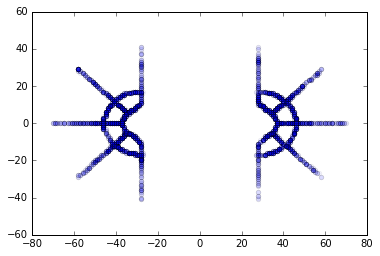

In [131]:
plt.scatter(h[:, 0], h[:, 1], alpha=0.025)